# Training a RandomForest Model from imbalanced data in pyspark

L'obiettivo è quello di allenare un modello con l'algoritmo RandomForest delle librerie di pyspark su un dataset sbilanciato per la predizione di guasti in ambito industruiale.

Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00601/

## Load data

Come prima cosa creaimo la SparkSession e importiamo il dataset:

In [1]:
# Necessary import
import pyspark
from pyspark.sql import SparkSession

# Create spark session
spark = SparkSession \
    .builder \
    .appName('Predictive analysis on industrial data') \
    .getOrCreate()
sc=spark.sparkContext

In [2]:
# Import and show dataset

df = (spark.read
          .format("csv")
          .option('header', 'true')
          .load("/home/annalisa/Scrivania/TESI/Dataset/ai4i2020.csv"))

df.toPandas()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,0,0,0,0,0


## Data exploration

Con *data exploration*, nota anche come *exploratory data analysis* (EDA), intendiamo il processo in cui andiamo ad esaminare e comprendere i dati con metodi statistici e di visualizzazione. Questo passaggio aiuta a identificare modelli e problemi nel set di dati.

Come prima cosa andiamo a vedere la struttura del nostro dataset che ci servirà per capire come manipolare successivamente i dati:

In [3]:
# Types of our columns
df.dtypes

[('UDI', 'string'),
 ('Product ID', 'string'),
 ('Type', 'string'),
 ('Air temperature [K]', 'string'),
 ('Process temperature [K]', 'string'),
 ('Rotational speed [rpm]', 'string'),
 ('Torque [Nm]', 'string'),
 ('Tool wear [min]', 'string'),
 ('Machine failure', 'string'),
 ('TWF', 'string'),
 ('HDF', 'string'),
 ('PWF', 'string'),
 ('OSF', 'string'),
 ('RNF', 'string')]

Innanzitutto vediamo che tutti i campi sono ti tipo *string* ma sappiamo che non è così, quindi andremo a castare le feature che sono valori numerici in *float/int* e possiamo anche andare ad eliminare le feature non necessarie alla predizione come la feature *UDI* e *Product ID*.

In [4]:
from pyspark.sql.functions import col

dataset = df.select(col('Type'),
                    col('Air temperature [K]').cast('float'),
                    col('Process temperature [K]').cast('float'),
                    col('Rotational speed [rpm]').cast('int'),
                    col('Torque [Nm]').cast('float'),
                    col('Tool wear [min]').cast('int'),
                    col('Machine failure').cast('int'),
                    col('TWF').cast('int'),
                    col('HDF').cast('int'),
                    col('PWF').cast('int'),
                    col('OSF').cast('int'),
                    col('RNF').cast('int'))
dataset.dtypes

[('Type', 'string'),
 ('Air temperature [K]', 'float'),
 ('Process temperature [K]', 'float'),
 ('Rotational speed [rpm]', 'int'),
 ('Torque [Nm]', 'float'),
 ('Tool wear [min]', 'int'),
 ('Machine failure', 'int'),
 ('TWF', 'int'),
 ('HDF', 'int'),
 ('PWF', 'int'),
 ('OSF', 'int'),
 ('RNF', 'int')]

Ora andiamo a vedere se ci sono dei record contententi valori nulli quindi inutili per la nostra previsione e successivamente ad eliminarli:

In [5]:
dataset = dataset.replace('?', None)\
        .dropna(how='any')

Per il nostro modello è necessario avere solo valori numerici, ma la feature *Type* è una stringa ed è necessaria alla predizione, allora utilizziamo la funzione *StringIndexer* che converte ogni valore di *Type* in un valore numerico mantenendo il senso dei dati.

In [6]:
from pyspark.ml.feature import StringIndexer

dataset = StringIndexer(
            inputCol='Type', 
            outputCol='T', 
            handleInvalid='keep').fit(dataset).transform(dataset)

dataset.toPandas()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,T
0,M,298.100006,308.600006,1551,42.799999,0,0,0,0,0,0,0,1.0
1,L,298.200012,308.700012,1408,46.299999,3,0,0,0,0,0,0,0.0
2,L,298.100006,308.500000,1498,49.400002,5,0,0,0,0,0,0,0.0
3,L,298.200012,308.600006,1433,39.500000,7,0,0,0,0,0,0,0.0
4,L,298.200012,308.700012,1408,40.000000,9,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,M,298.799988,308.399994,1604,29.500000,14,0,0,0,0,0,0,1.0
9996,H,298.899994,308.399994,1632,31.799999,17,0,0,0,0,0,0,2.0
9997,M,299.000000,308.600006,1645,33.400002,22,0,0,0,0,0,0,1.0
9998,H,299.000000,308.700012,1408,48.500000,25,0,0,0,0,0,0,2.0


Ora che abbiamo creato una colonna equivalente di *Type* possiamo andare ad eliminarla:

In [7]:
# Drop unnecessary columns

dataset = dataset.drop('Type')
dataset = dataset.withColumnRenamed('T', 'Type')
dataset.toPandas()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type
0,298.100006,308.600006,1551,42.799999,0,0,0,0,0,0,0,1.0
1,298.200012,308.700012,1408,46.299999,3,0,0,0,0,0,0,0.0
2,298.100006,308.500000,1498,49.400002,5,0,0,0,0,0,0,0.0
3,298.200012,308.600006,1433,39.500000,7,0,0,0,0,0,0,0.0
4,298.200012,308.700012,1408,40.000000,9,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,298.799988,308.399994,1604,29.500000,14,0,0,0,0,0,0,1.0
9996,298.899994,308.399994,1632,31.799999,17,0,0,0,0,0,0,2.0
9997,299.000000,308.600006,1645,33.400002,22,0,0,0,0,0,0,1.0
9998,299.000000,308.700012,1408,48.500000,25,0,0,0,0,0,0,2.0


Ora che abbiamo fatto una preparazione e pulizia dei dati possiamo andare a vedere alcune informazioni generali, per esempio alcune statistiche come numero di record, media, scarto quadratico medio, minimo e massimo:

In [8]:
# Basics stats from our columns
dataset.describe().toPandas()

,summary,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type
0,count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,mean,300.004929788208,310.0055601776123,1538.7761,39.98690999906063,107.951,0.0339,0.0046,0.0115,0.0095,0.0098,0.0019,0.5003
2,stddev,2.0002587855049776,1.4837342558800704,179.28409591342677,9.96893374241202,63.65414663663629,0.180980842650654,0.06767051004531441,0.10662498247919601,0.09700871645943422,0.0985136056240423,0.04354973774853086,0.671300956723174
3,min,295.3,305.7,1168,3.8,0,0,0,0,0,0,0,0.0
4,max,304.5,313.8,2886,76.6,253,1,1,1,1,1,1,2.0


Vediamo la distribuzione delle features del nostro dataset attraverso istogrammi:

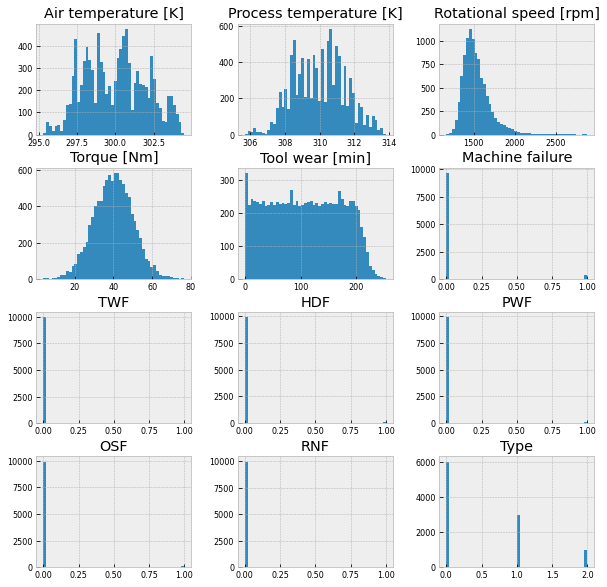

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('bmh')

pandasDF = dataset.toPandas()
pandasDF.hist(figsize=(10, 10), bins=50, xlabelsize=8, ylabelsize=8);

Ora vediamo le relazioni tra le varie features rispetto alla feature di riferimento *Machine failure*:

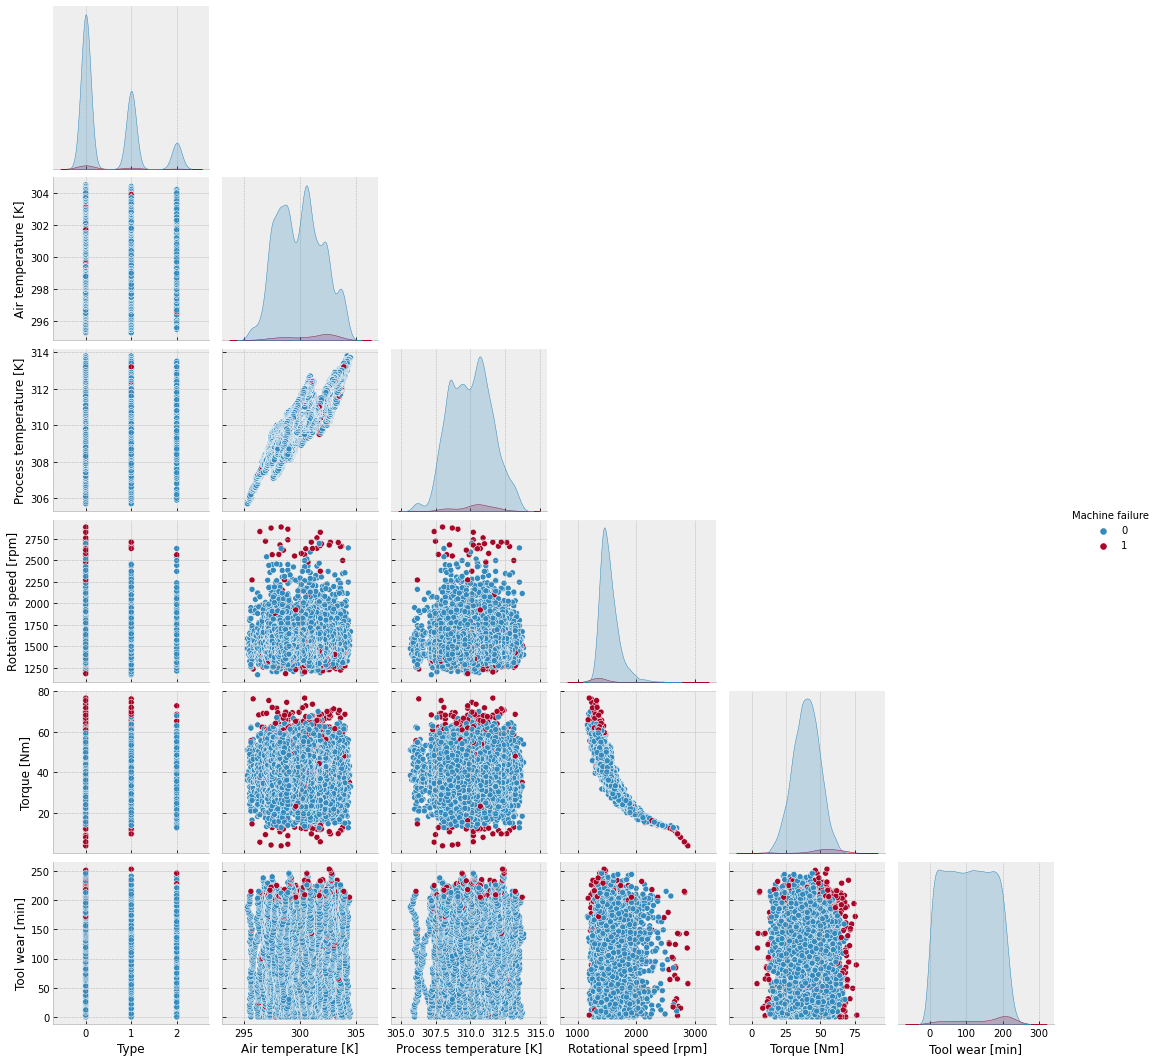

In [10]:
sns.pairplot(data=pandasDF,
            hue='Machine failure',
            kind='scatter',
            dropna= True,
            corner=True,
            x_vars=['Type','Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]'],
            y_vars=['Type','Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]'])


Ora andiamo a visualizzare il grafico Principal Component Analysis (PCA). L'analisi delle componenti principali (PCA) è una tecnica di riduzione della dimensionalità lineare che può essere utilizzata per estrarre informazioni da uno spazio ad alta dimensione proiettandole in un sottospazio a dimensione inferiore.

Text(0.5, 1.0, 'Number of observations per class')

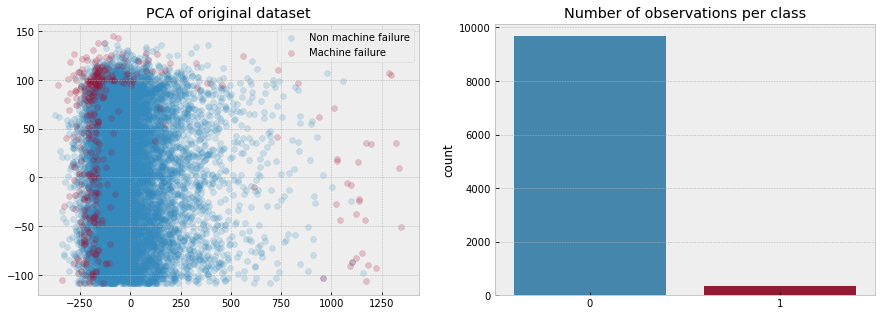

In [11]:
from sklearn.decomposition import PCA
import numpy as np

# selezione le colonne indipendenti e rilevanti alla predizione
feature_df = pandasDF[['Type',
                         'Air temperature [K]',
                         'Process temperature [K]', 
                         'Rotational speed [rpm]', 
                         'Torque [Nm]',
                         'Tool wear [min]',
                          'TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

# variabili indipendenti
X = np.asarray(feature_df)

# variabile dipendente
y = np.asarray(pandasDF['Machine failure'])

# Reduce dataset to 2 feature dimensions in order to visualize the data
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="Non machine failure", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="Machine failure", alpha=0.2)
ax[0].set_title('PCA of original dataset')
ax[0].legend()

ax[1] = sns.countplot(x=y)
ax[1].set_title('Number of observations per class')

Da queste distribuziozioni vediamo che il nostro dataset è molto sbilanciato quindi andrà bilanciato a dovere nei prossimi passaggi.

## Modify dataset for prediction

In quanto l'obiettivo di questo progetto è la predizione degli errori, è necessario andare a modificare il dataset per fare in modo che il modello sia in grado di classificare correttamente le tuple che precedono l'errore. Per fare ciò andremo a ri-labellare il dataset andando a identificare con la label 1 le tuple che precedono l'errore, eliminando dal dataset le tuple che generano un machine failure e infine lasciando invariate le tuple che non precedono un errore e quelle che non sono errore.

In [12]:
def re_labeling(df):

    df_index = df.index
    errors_index = df[df['Machine failure'] == 1].index
    index = []

    #caso particolare in cui l'errore e' al primo record
    if errors_index[0] == 0:
        i = -1
        while df_index[i] in errors_index:
            i -= 1
        index.append(df_index[i])

    #gestione di più errori consecutivi
    i = 0
    while i < len(errors_index):
        next = 1
        while (i + next < len(errors_index) and errors_index[i] + next == errors_index[i + next]):
            next += 1
        index.append(errors_index[i] - 1)
        i = i + next


    #drop errors
    df = df.drop(errors_index)

    #re-labeling
    for i in index:
        df.at[i,'Machine failure'] = 1

    return df

In [13]:
dataset = re_labeling(pandasDF)

In [14]:
dataset.groupby('Machine failure').count()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type
Machine failure,,,,,,,,,,,
0,9351,9351,9351,9351,9351,9351,9351,9351,9351,9351,9351
1,310,310,310,310,310,310,310,310,310,310,310


## Divide dataset in Training-set and Testing-Set

Una volta pronto il dataset, andiamo a dividerlo in due: l'80% sarà il training set che useremo appunto per l'addestramento e il restante 20% sarà il testing set che useremo per testare il modello una volta addestrato.

In [15]:
dataset = spark.createDataFrame(dataset)
(training_data, test_data) = dataset.randomSplit([0.8,0.2])

print("Training set: ", training_data.count(), '\n'
      "Testing set: ", test_data.count())

Training set:  7711 
Testing set:  1950


Abbiamo ottenuto dunque un Taining set da 7963 tuple e un Testing set da 2037 tuple.

Ora andiamo a contare il numero di *Machine failure* rispettivamente del Training set e del Testing set:

In [16]:
data=training_data.toPandas()
data['Machine failure'].value_counts()

0    7467
1     244
Name: Machine failure, dtype: int64

In [17]:
data=test_data.toPandas()
data['Machine failure'].value_counts()

0    1884
1      66
Name: Machine failure, dtype: int64

## Balance dataset

Avendo un dataset sbilanciato dobbiamo andare a bilanciarlo provando varie tecniche.

**SMOTE**

In [18]:
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

def datasetBalancingWithSMOTE(data, independent_features=[], dipendent_feature=[]):
    
    '''
    @Param
        data: spark dataframe, dataset da bilanciare
        independent_features[]: vettore contenente l'elenco delle variabili indipendenti
        dipendent_feature: variabile dipendente
    @returns
        smote_dataset: spark dataframe
    '''
    
    # df_spark --> df_pandas
    df = data.toPandas()
    
    # selezione le colonne indipendenti e rilevanti alla predizione
    feature_df = df[independent_features]
    
    # variabile indipendente
    X = np.asarray(feature_df)

    # variabile dipendente
    y = np.asarray(df[dipendent_feature])
    
    smote = SMOTE(random_state=42)

    # fit predictor and target variable
    x_smote, y_smote = smote.fit_resample(X, y)
    
    smote_xdf = pd.DataFrame(x_smote, columns = independent_features)
    smote_ydf = pd.DataFrame(y_smote, columns = dipendent_feature)
    smote_df = pd.merge(smote_xdf, smote_ydf[dipendent_feature], how = 'left',left_index = True, right_index = True)
    
    smote_dataset=spark.createDataFrame(smote_df) 
    
    smote_dataset = smote_dataset.select(col('Type').cast('double'),
                                            col('Air temperature [K]'),
                                            col('Process temperature [K]'),
                                            col('Rotational speed [rpm]').cast('int'),
                                            col('Torque [Nm]'),
                                            col('Tool wear [min]').cast('int'),
                                            col('Machine failure').cast('int'),
                                            col('TWF').cast('int'),
                                            col('HDF').cast('int'),
                                            col('PWF').cast('int'),
                                            col('OSF').cast('int'),
                                            col('RNF').cast('int'))
    
    return smote_dataset

Bilanciamo il Training e il Testing set con la funzione *datasetBalancingWithSMOTE* e andiamo a controllare l'esito del bilanciamento contanto il numero di *Machine failure*:

In [19]:
smote_trainingSet = datasetBalancingWithSMOTE(training_data, 
                                              independent_features=['Type',
                                                                     'Air temperature [K]',
                                                                     'Process temperature [K]', 
                                                                     'Rotational speed [rpm]', 
                                                                     'Torque [Nm]',
                                                                     'Tool wear [min]',
                                                                      'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
                                              dipendent_feature=['Machine failure'])
smote_trainingSet.groupBy('Machine failure').count().show()

+---------------+-----+
|Machine failure|count|
+---------------+-----+
|              1| 7467|
|              0| 7467|
+---------------+-----+



In [20]:
smote_testingSet = datasetBalancingWithSMOTE(test_data, 
                                              independent_features=['Type',
                                                                     'Air temperature [K]',
                                                                     'Process temperature [K]', 
                                                                     'Rotational speed [rpm]', 
                                                                     'Torque [Nm]',
                                                                     'Tool wear [min]',
                                                                      'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
                                              dipendent_feature=['Machine failure'])
smote_testingSet.groupBy('Machine failure').count().show()

+---------------+-----+
|Machine failure|count|
+---------------+-----+
|              1| 1884|
|              0| 1884|
+---------------+-----+



**Oversampling**

In [21]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

def randomOversampling(data, independent_features=[], dipendent_feature=[]):

    '''
    @Param
        data: spark dataframe, dataset da bilanciare
        independent_features[]: vettore contenente l'elenco delle variabili indipendenti
        dipendent_feature: variabile dipendente
    @returns
        over_dataset: spark dataframe
    '''
    
    # df_spark --> df_pandas
    df = data.toPandas()
    
    # selezione le colonne indipendenti e rilevanti alla predizione
    feature_df = df[independent_features]
    
    # variabile indipendente
    X = np.asarray(feature_df)

    # variabile dipendente
    y = np.asarray(df[dipendent_feature])
    #print(Counter(y))
    
    oversample = RandomOverSampler(sampling_strategy='minority')
    
    # fit and apply the transform
    X_over, y_over = oversample.fit_resample(X, y)
    # summarize class distribution
    #print(Counter(y_over))
    
    over_xdf = pd.DataFrame(X_over, columns = independent_features)
    over_ydf = pd.DataFrame(y_over, columns = dipendent_feature)
    over_df = pd.merge(over_xdf, over_ydf[dipendent_feature], how = 'left',left_index = True, right_index = True)
    
    over_dataset = spark.createDataFrame(over_df) 
    
    over_dataset = over_dataset.select(col('Type').cast('double'),
                                        col('Air temperature [K]'),
                                        col('Process temperature [K]'),
                                        col('Rotational speed [rpm]').cast('int'),
                                        col('Torque [Nm]'),
                                        col('Tool wear [min]').cast('int'),
                                        col('Machine failure').cast('int'),
                                        col('TWF').cast('int'),
                                        col('HDF').cast('int'),
                                        col('PWF').cast('int'),
                                        col('OSF').cast('int'),
                                        col('RNF').cast('int'))
    
    return over_dataset

Bilanciamo il Training e il Testing set con la funzione *randomOversampling* e andiamo a controllare l'esito del bilanciamento contanto il numero di *Machine failure*:

In [22]:
over_trainingSet = randomOversampling(training_data,
                                       independent_features=['Type',
                                                             'Air temperature [K]',
                                                             'Process temperature [K]', 
                                                             'Rotational speed [rpm]', 
                                                             'Torque [Nm]',
                                                             'Tool wear [min]',
                                                              'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
                                        dipendent_feature=['Machine failure'])
over_trainingSet.groupBy('Machine failure').count().show()

+---------------+-----+
|Machine failure|count|
+---------------+-----+
|              1| 7467|
|              0| 7467|
+---------------+-----+



In [23]:
over_testingSet = randomOversampling(test_data,
                                       independent_features=['Type',
                                                             'Air temperature [K]',
                                                             'Process temperature [K]', 
                                                             'Rotational speed [rpm]', 
                                                             'Torque [Nm]',
                                                             'Tool wear [min]',
                                                              'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
                                        dipendent_feature=['Machine failure'])
over_testingSet.groupBy('Machine failure').count().show()

+---------------+-----+
|Machine failure|count|
+---------------+-----+
|              1| 1884|
|              0| 1884|
+---------------+-----+



**Undersampling**

In [24]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

def randomUndersampling(data, independent_features=[], dipendent_feature=[]):

    '''
    @Param
        data: spark dataframe, dataset da bilanciare
        independent_features[]: vettore contenente l'elenco delle variabili indipendenti
        dipendent_feature: variabile dipendente
    @returns
        under_dataset: spark dataframe
    '''
    
    # df_spark --> df_pandas
    df = data.toPandas()
    
    # selezione le colonne indipendenti e rilevanti alla predizione
    feature_df = df[independent_features]
    
    # variabile indipendente
    X = np.asarray(feature_df)

    # variabile dipendente
    y = np.asarray(df[dipendent_feature])
    #print(Counter(y))
    
    undersample = RandomUnderSampler(sampling_strategy='majority')
    
    # fit and apply the transform
    X_under, y_under = undersample.fit_resample(X, y)
    # summarize class distribution
    #print(Counter(y_over))
    
    under_xdf = pd.DataFrame(X_under, columns = independent_features)
    under_ydf = pd.DataFrame(y_under, columns = dipendent_feature)
    under_df = pd.merge(under_xdf, under_ydf[dipendent_feature], how = 'left',left_index = True, right_index = True)
    
    under_dataset = spark.createDataFrame(under_df) 
    
    under_dataset = under_dataset.select(col('Type').cast('double'),
                                        col('Air temperature [K]'),
                                        col('Process temperature [K]'),
                                        col('Rotational speed [rpm]').cast('int'),
                                        col('Torque [Nm]'),
                                        col('Tool wear [min]').cast('int'),
                                        col('Machine failure').cast('int'),
                                        col('TWF').cast('int'),
                                        col('HDF').cast('int'),
                                        col('PWF').cast('int'),
                                        col('OSF').cast('int'),
                                        col('RNF').cast('int'))
    
    return under_dataset

Bilanciamo il Training e il Testing set con la funzione *randomUndersampling* e andiamo a controllare l'esito del bilanciamento contanto il numero di *Machine failure*:

In [25]:
under_trainingSet = randomUndersampling(training_data,
                                       independent_features=['Type',
                                                             'Air temperature [K]',
                                                             'Process temperature [K]', 
                                                             'Rotational speed [rpm]', 
                                                             'Torque [Nm]',
                                                             'Tool wear [min]',
                                                              'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
                                        dipendent_feature=['Machine failure'])
under_trainingSet.groupBy('Machine failure').count().show()

+---------------+-----+
|Machine failure|count|
+---------------+-----+
|              1|  244|
|              0|  244|
+---------------+-----+



In [26]:
under_testingSet = randomUndersampling(test_data,
                                       independent_features=['Type',
                                                             'Air temperature [K]',
                                                             'Process temperature [K]', 
                                                             'Rotational speed [rpm]', 
                                                             'Torque [Nm]',
                                                             'Tool wear [min]',
                                                              'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
                                        dipendent_feature=['Machine failure'])
under_testingSet.groupBy('Machine failure').count().show()

+---------------+-----+
|Machine failure|count|
+---------------+-----+
|              1|   66|
|              0|   66|
+---------------+-----+



## Compute weights

Con l'algoritmo RandomForest è possibile addestrare il modello con dei pesi per ottimizzare al meglio l'addestramento, in particolare per quanto riguarda il dataset sbilanciato.

In [27]:
def computeWeights(df):
    
    counts = df.groupBy('Machine failure').count().toPandas()
    # Counts
    count_mf = counts[counts['Machine failure']==1]['count'].values[0]
    count_total = counts['count'].sum()

    # Weights
    c = 2
    weight_mf = count_total / (c * count_mf)
    weight_no_mf = count_total / (c * (count_total - count_mf))
    weight_null = 1.0

    # Append weights to the dataset
    from pyspark.sql.functions import col
    from pyspark.sql.functions import when

    df = df.withColumn("weight_0", when(col("Machine failure") ==1, weight_null).otherwise(weight_null)) # peso nullo
    df = df.withColumn("weight_1", when(col("Machine failure") ==1, weight_mf).otherwise(weight_no_mf))

    # Check everything seems ok
    df.select('Machine failure', 'weight_0', 'weight_1').show(3)
    return df

In [28]:
training_data = computeWeights(training_data)
smote_trainingSet = computeWeights(smote_trainingSet)
over_trainingSet = computeWeights(over_trainingSet)
under_trainingSet = computeWeights(under_trainingSet)

+---------------+--------+------------------+
|Machine failure|weight_0|          weight_1|
+---------------+--------+------------------+
|              0|     1.0|0.5163385563144502|
|              0|     1.0|0.5163385563144502|
|              0|     1.0|0.5163385563144502|
+---------------+--------+------------------+
only showing top 3 rows

+---------------+--------+--------+
|Machine failure|weight_0|weight_1|
+---------------+--------+--------+
|              0|     1.0|     1.0|
|              0|     1.0|     1.0|
|              0|     1.0|     1.0|
+---------------+--------+--------+
only showing top 3 rows

+---------------+--------+--------+
|Machine failure|weight_0|weight_1|
+---------------+--------+--------+
|              0|     1.0|     1.0|
|              0|     1.0|     1.0|
|              0|     1.0|     1.0|
+---------------+--------+--------+
only showing top 3 rows

+---------------+--------+--------+
|Machine failure|weight_0|weight_1|
+---------------+--------+-

## Cross validation

Una volta bilanciato il dataset e calcolati i pesi è il momento di allenare il modello. Per allenare il modello utilizziamo la tecnica di cross validation che ci permette di allenare più modelli con vari subset del training set per ottenere il modello migliore.

In [29]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.sql import Row
import itertools
import numpy as np
import time
 
def crossValidation(sparkDF, k):
    data = []
    validation_subsets = [0 for x in range(k)]
    training_subsets = [0 for x in range(k)]
    
    for i in range(k):
        validation_subsets[i] = pd.DataFrame(data)
        training_subsets[i] = pd.DataFrame(data)
    
    df = sparkDF.toPandas()

    # Split dataset in k fold
    shuffled = df.sample(frac=1)
    subsets = np.array_split(shuffled, k) 
    
    for i in range(0, k):
        for j in range(0, k):
            if i==j:
                validation_subsets[i] = subsets[i]
            else:
                training_subsets[i] = pd.concat([training_subsets[i], subsets[j]])

    # model parameters
    model_number = 0
    weight_0 = 'weight_0'
    weight_1 = 'weight_1'
    weights = [weight_0, weight_1]
    best_model_number = None
    best_model = None
    best_prediction_df = None
    best_prediction_lp = None
    best_balancedAccuracy = 0
    best_accuracy = 0
    best_trainErr = 0
    best_errors = 0
    best_iter = None
    best_stepSize = None
    best_regParam = None
    best_weight = None
    
    # grid training
    start = time.time()
    for i in range(k):
        for weights in itertools.product(weights):
            model_number += 1

            # [TRAIN] Train the model
            print(">>>>> Building model #%i.." % (model_number))

            training_data = spark.createDataFrame(training_subsets[i])
            w = str(weights)[2:-3]
            rfc = RandomForestClassifier(labelCol="labelIndex", featuresCol="features", numTrees=10, weightCol=w)
            model = rfc.fit(training_data)

            # [TEST] Guess labels on test data
            print(">>>>> Testing model #%i.." % (model_number))

            validation_data = spark.createDataFrame(validation_subsets[i])
            predictions = model.transform(validation_data)

            # [EVALUATION] the model on training data
            print(">>>>> Evaluating model #%i.." % (model_number))

            prediction_df = predictions.toPandas()
            y_test = prediction_df[['labelIndex']].to_numpy()
            y_score = prediction_df[['prediction']].to_numpy()

            # Confusion matrix
            from sklearn.metrics import confusion_matrix
            tn, fp, fn, tp = confusion_matrix(y_test, y_score).ravel()

            sensitivity = tp/(tp+fn)
            specificity = tn/(fp+tn)

            correct_prediction = tp + tn
            incorrect_prediction = fp + fn
            total_prediction = predictions.count()

            accuracy = correct_prediction/total_prediction
            trainErr = incorrect_prediction/total_prediction
            balanced_accuracy = (sensitivity+specificity)/2

            # Is it the best model yet?
            if balanced_accuracy > best_balancedAccuracy:
                best_model_number = model_number
                best_model = model
                best_prediction_df = prediction_df
                best_prediction_lp = predictions
                best_balancedAccuracy = balanced_accuracy
                best_accuracy = accuracy
                best_trainErr = trainErr
                best_errors = incorrect_prediction
                best_weight = w

            # [RESULTS]

            print("""
            |Model #%i
            |Model trained with: %s
            |Balanced accuracy of %.3f 
            |Accuracy of %.3f
            |(errors: %i / training error: %.3f) on test
            """ % (model_number, w, balanced_accuracy, accuracy,incorrect_prediction,trainErr))
        
    # [RESULTS]
    # Display results for best model
    print("""
    |Model #%i is the best model
    |Model trained with: %s
    |Balanced accuracy of %.3f 
    |Accuracy of %.3f 
    |(errors: %i / training error: %.3f) on test
    """ % (best_model_number, best_weight, best_balancedAccuracy,best_accuracy,best_errors,best_trainErr))
    
    stop = time.time()
    print("Seconds for calculate the best model: ", stop-start)
    
    return best_model

In [30]:
from pyspark.ml.feature import VectorAssembler
def prepareDataInput(data):

    vector_assembler = VectorAssembler(inputCols=['Type',
                                                  'Air temperature [K]',
                                                  'Process temperature [K]',
                                                  'Rotational speed [rpm]',
                                                  'Torque [Nm]',
                                                  'Tool wear [min]',
                                                  'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
                                      outputCol="features")
    df_temp = vector_assembler.transform(data)
    df = df_temp.drop('Type','Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF')
    df = df.withColumnRenamed('Machine failure', 'label')
    l_indexer = StringIndexer(inputCol="label", outputCol="labelIndex")
    df = l_indexer.fit(df).transform(df)

    return df

Ora possiamo allenare vari modelli con il dataset sbilanciato e con i dataset bilanciati:

**Modello su dataset sbilanciato**

In [31]:
data = prepareDataInput(training_data)
unbalanced_model = crossValidation(data, 4)

>>>>> Building model #1..
>>>>> Testing model #1..
>>>>> Evaluating model #1..

            |Model #1
            |Model trained with: weight_0
            |Balanced accuracy of 0.500 
            |Accuracy of 0.973
            |(errors: 53 / training error: 0.027) on test
            
>>>>> Building model #2..
>>>>> Testing model #2..
>>>>> Evaluating model #2..

            |Model #2
            |Model trained with: weight_1
            |Balanced accuracy of 0.660 
            |Accuracy of 0.802
            |(errors: 382 / training error: 0.198) on test
            
>>>>> Building model #3..
>>>>> Testing model #3..
>>>>> Evaluating model #3..

            |Model #3
            |Model trained with: weight_1
            |Balanced accuracy of 0.740 
            |Accuracy of 0.811
            |(errors: 364 / training error: 0.189) on test
            
>>>>> Building model #4..
>>>>> Testing model #4..
>>>>> Evaluating model #4..

            |Model #4
            |Model trained with: we

**Modello su dataset bilanciato con SMOTE**

In [32]:
data = prepareDataInput(smote_trainingSet)
smote_model = crossValidation(data, 4)

>>>>> Building model #1..
>>>>> Testing model #1..
>>>>> Evaluating model #1..

            |Model #1
            |Model trained with: weight_0
            |Balanced accuracy of 0.763 
            |Accuracy of 0.763
            |(errors: 885 / training error: 0.237) on test
            
>>>>> Building model #2..
>>>>> Testing model #2..
>>>>> Evaluating model #2..

            |Model #2
            |Model trained with: weight_1
            |Balanced accuracy of 0.763 
            |Accuracy of 0.763
            |(errors: 885 / training error: 0.237) on test
            
>>>>> Building model #3..
>>>>> Testing model #3..
>>>>> Evaluating model #3..

            |Model #3
            |Model trained with: weight_1
            |Balanced accuracy of 0.786 
            |Accuracy of 0.787
            |(errors: 797 / training error: 0.213) on test
            
>>>>> Building model #4..
>>>>> Testing model #4..
>>>>> Evaluating model #4..

            |Model #4
            |Model trained with: w

**Modello su dataset bilanciato con Oversamplin**

In [33]:
data = prepareDataInput(over_trainingSet)
over_model = crossValidation(data, 4)

>>>>> Building model #1..
>>>>> Testing model #1..
>>>>> Evaluating model #1..

            |Model #1
            |Model trained with: weight_0
            |Balanced accuracy of 0.771 
            |Accuracy of 0.771
            |(errors: 854 / training error: 0.229) on test
            
>>>>> Building model #2..
>>>>> Testing model #2..
>>>>> Evaluating model #2..

            |Model #2
            |Model trained with: weight_1
            |Balanced accuracy of 0.771 
            |Accuracy of 0.771
            |(errors: 854 / training error: 0.229) on test
            
>>>>> Building model #3..
>>>>> Testing model #3..
>>>>> Evaluating model #3..

            |Model #3
            |Model trained with: weight_1
            |Balanced accuracy of 0.770 
            |Accuracy of 0.770
            |(errors: 859 / training error: 0.230) on test
            
>>>>> Building model #4..
>>>>> Testing model #4..
>>>>> Evaluating model #4..

            |Model #4
            |Model trained with: w

**Modello su dataset bilanciato con Undersampling**

In [34]:
data = prepareDataInput(under_trainingSet)
under_model = crossValidation(data, 4)

>>>>> Building model #1..
>>>>> Testing model #1..
>>>>> Evaluating model #1..

            |Model #1
            |Model trained with: weight_0
            |Balanced accuracy of 0.691 
            |Accuracy of 0.689
            |(errors: 38 / training error: 0.311) on test
            
>>>>> Building model #2..
>>>>> Testing model #2..
>>>>> Evaluating model #2..

            |Model #2
            |Model trained with: weight_1
            |Balanced accuracy of 0.691 
            |Accuracy of 0.689
            |(errors: 38 / training error: 0.311) on test
            
>>>>> Building model #3..
>>>>> Testing model #3..
>>>>> Evaluating model #3..

            |Model #3
            |Model trained with: weight_1
            |Balanced accuracy of 0.738 
            |Accuracy of 0.738
            |(errors: 32 / training error: 0.262) on test
            
>>>>> Building model #4..
>>>>> Testing model #4..
>>>>> Evaluating model #4..

            |Model #4
            |Model trained with: weig

## Prediction and evaluation

Una volta ottenuto i migliori modelli è il momento di testarli sui Testing set e valutarli:

In [35]:
from handyspark import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings


def evaluateModel(model, testSet):
    
    predictions = model.transform(testSet)
    prediction_df = predictions.toPandas()
    y_test = prediction_df[['labelIndex']].to_numpy()
    y_score = prediction_df[['prediction']].to_numpy()
    
    print("-------------------------VALUTAZIONE DEL MODELLO-------------------------")
    print("\n>>> Matrice di confusione:\n")
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_score).ravel()
    
    data = {'Classificati come positivi':[tp, fp],
            'Classificati come negativi':[fn, tn]}
    df = pd.DataFrame(data, index =['Classe 1',
                                    'Classe 0'])
    print(df)
    tn=np.array(tn)
    fp=np.array(fp)
    fn=np.array(fn)
    tp=np.array(tp)
    
    print("\n>>> Metriche di soglia:\n")

    sensitivity = tp/(tp+fn)
    specificity = tn/(fp+tn)
    g_mean = math.sqrt(sensitivity*specificity)
    
    data = {'Sensibilità':[sensitivity],
            'Specificità':[specificity],
            'G-mean':[g_mean]}
    df = pd.DataFrame(data, index =[' '])
    print(df)
    
    correct_prediction = tp + tn
    incorrect_prediction = fp + fn
    total_prediction = predictions.count()
    
    accuracy = correct_prediction/total_prediction
    trainErr = incorrect_prediction/total_prediction
    balanced_accuracy = (sensitivity+specificity)/2
    
    print("\n")
    data = {'':[accuracy, trainErr, balanced_accuracy],
            'Supporto':[total_prediction, total_prediction, total_prediction]}
    df = pd.DataFrame(data, index =['Accuratezza',
                                    'Errore',
                                    'Accuratezza bilanciata'])
    print(df)
    
    print("\n")
    print(metrics.classification_report(y_test,  y_score))

    print("\n>>> Metriche di ranking:\n")

    predictions = predictions.rdd
    new_rdd = predictions.map(lambda row: Row(
        prediction=row.prediction, 
        labelIndex=row.labelIndex))
    bcm = BinaryClassificationMetrics(new_rdd, scoreCol='prediction', labelCol='labelIndex')
    pr_auc = bcm.areaUnderPR
    roc_auc = bcm.areaUnderROC

    
    from sklearn.metrics import precision_recall_curve, roc_curve
    from matplotlib import pyplot as plt
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_score)
    ns_probs = [0 for _ in range(len(y_test))]
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_score)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    plt.subplots(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='ROC curve (area = '+ str(roc_auc)+')')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot([no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='PR curve (area = '+str(pr_auc)+')')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-Curve')
    plt.legend()
    
    plt.show()
    
    print("\n>>> Feature importance:\n")
    importance = model.featureImportances 
    plt.subplots(figsize=(15, 8))
    plt.bar([x for x in range(len(importance))], 
            importance, 
            tick_label = ['Type','Air temp','Process temp','Rot speed ','Torque','Tool wear','TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 
            align='center')
    
    plt.show()
    return

**Testing sul Testing set sbilanciato**

-------------------------VALUTAZIONE DEL MODELLO-------------------------

>>> Matrice di confusione:

          Classificati come positivi  Classificati come negativi
Classe 1                          36                          30
Classe 0                         380                        1504

>>> Metriche di soglia:

   Sensibilità  Specificità    G-mean
      0.545455     0.798301  0.659877


                                  Supporto
Accuratezza             0.789744      1950
Errore                  0.210256      1950
Accuratezza bilanciata  0.671878      1950


              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      1884
         1.0       0.09      0.55      0.15        66

    accuracy                           0.79      1950
   macro avg       0.53      0.67      0.51      1950
weighted avg       0.95      0.79      0.86      1950


>>> Metriche di ranking:



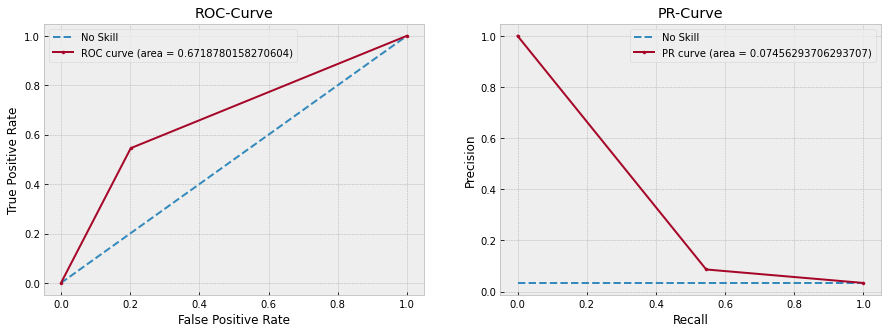


>>> Feature importance:



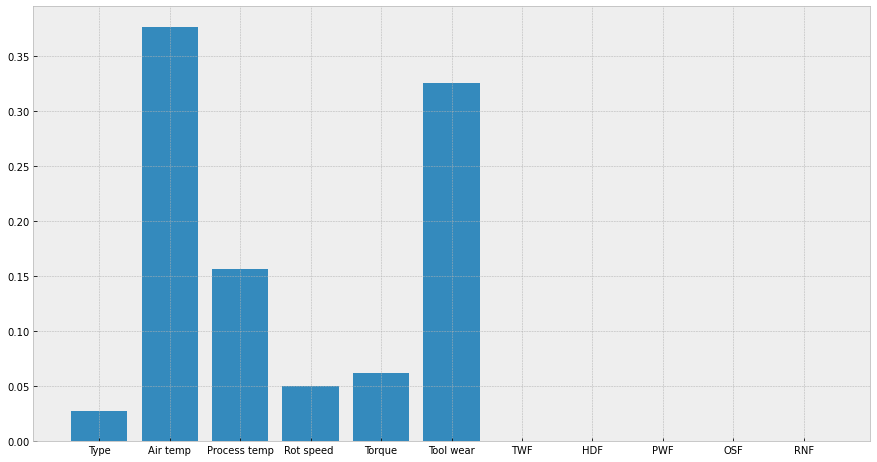

In [36]:
data = prepareDataInput(test_data)
evaluateModel(unbalanced_model, data)

**Testing sul Testing set bilanciato con SMOTE**

-------------------------VALUTAZIONE DEL MODELLO-------------------------

>>> Matrice di confusione:

          Classificati come positivi  Classificati come negativi
Classe 1                        1516                         368
Classe 0                         500                        1384

>>> Metriche di soglia:

   Sensibilità  Specificità    G-mean
      0.804671     0.734607  0.768841


                                  Supporto
Accuratezza             0.769639      3768
Errore                  0.230361      3768
Accuratezza bilanciata  0.769639      3768


              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76      1884
         1.0       0.75      0.80      0.78      1884

    accuracy                           0.77      3768
   macro avg       0.77      0.77      0.77      3768
weighted avg       0.77      0.77      0.77      3768


>>> Metriche di ranking:



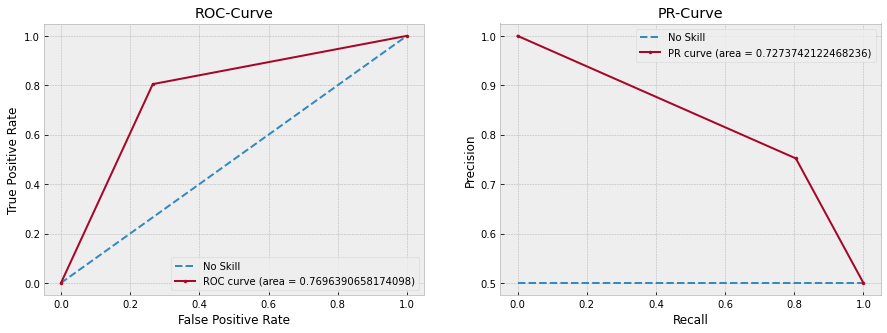


>>> Feature importance:



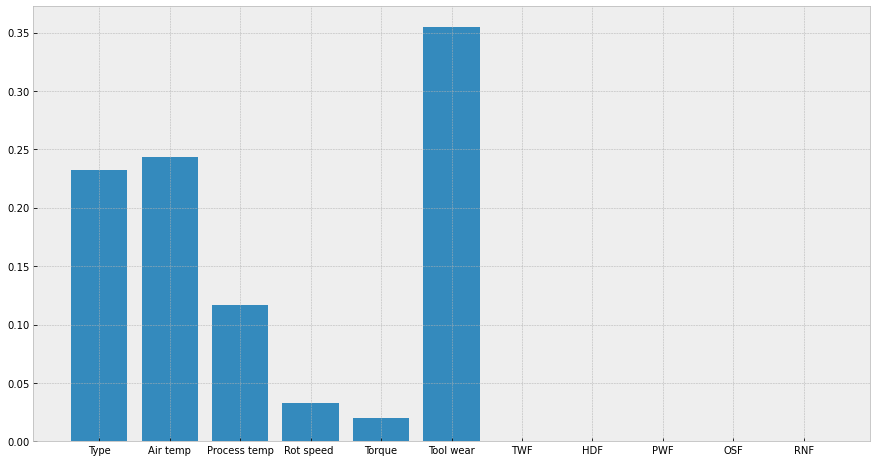

In [37]:
test = prepareDataInput(smote_testingSet)
evaluateModel(smote_model, test)

**Testing sul Testing set bilanciato con Oversampling**

-------------------------VALUTAZIONE DEL MODELLO-------------------------

>>> Matrice di confusione:

          Classificati come positivi  Classificati come negativi
Classe 1                        1301                         583
Classe 0                         517                        1367

>>> Metriche di soglia:

   Sensibilità  Specificità    G-mean
      0.690552     0.725584  0.707851


                                  Supporto
Accuratezza             0.708068      3768
Errore                  0.291932      3768
Accuratezza bilanciata  0.708068      3768


              precision    recall  f1-score   support

         0.0       0.70      0.73      0.71      1884
         1.0       0.72      0.69      0.70      1884

    accuracy                           0.71      3768
   macro avg       0.71      0.71      0.71      3768
weighted avg       0.71      0.71      0.71      3768


>>> Metriche di ranking:



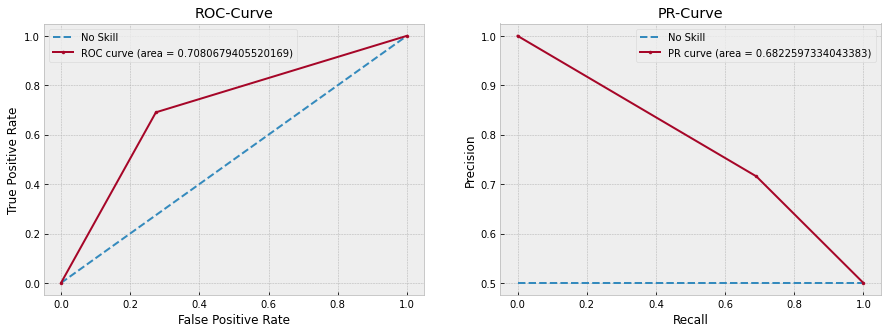


>>> Feature importance:



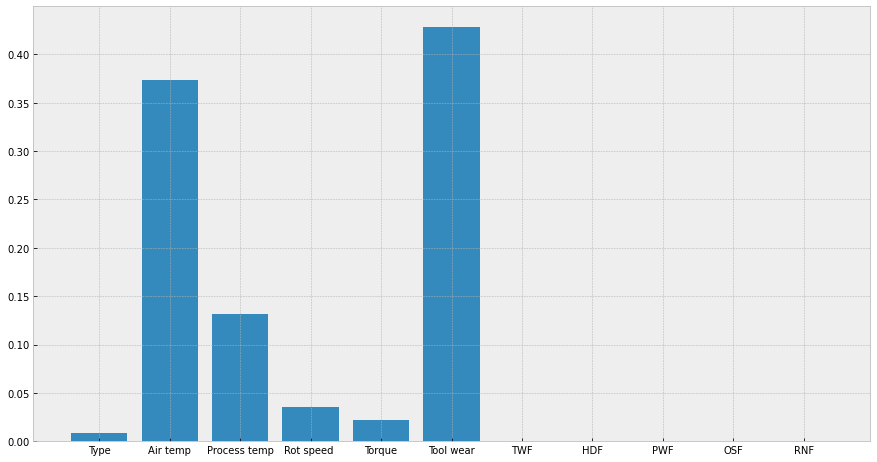

In [38]:
test = prepareDataInput(over_testingSet)
evaluateModel(over_model, test)

**Testing sul Testing set bilanciato con Undersampling**

-------------------------VALUTAZIONE DEL MODELLO-------------------------

>>> Matrice di confusione:

          Classificati come positivi  Classificati come negativi
Classe 1                          43                          23
Classe 0                          20                          46

>>> Metriche di soglia:

   Sensibilità  Specificità    G-mean
      0.651515      0.69697  0.673859


                                  Supporto
Accuratezza             0.674242       132
Errore                  0.325758       132
Accuratezza bilanciata  0.674242       132


              precision    recall  f1-score   support

         0.0       0.67      0.70      0.68        66
         1.0       0.68      0.65      0.67        66

    accuracy                           0.67       132
   macro avg       0.67      0.67      0.67       132
weighted avg       0.67      0.67      0.67       132


>>> Metriche di ranking:



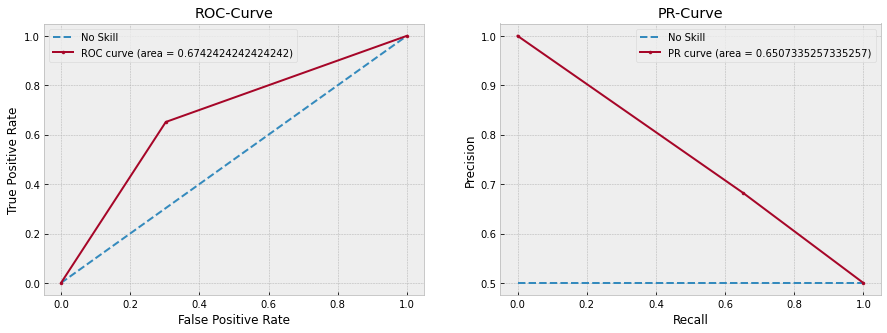


>>> Feature importance:



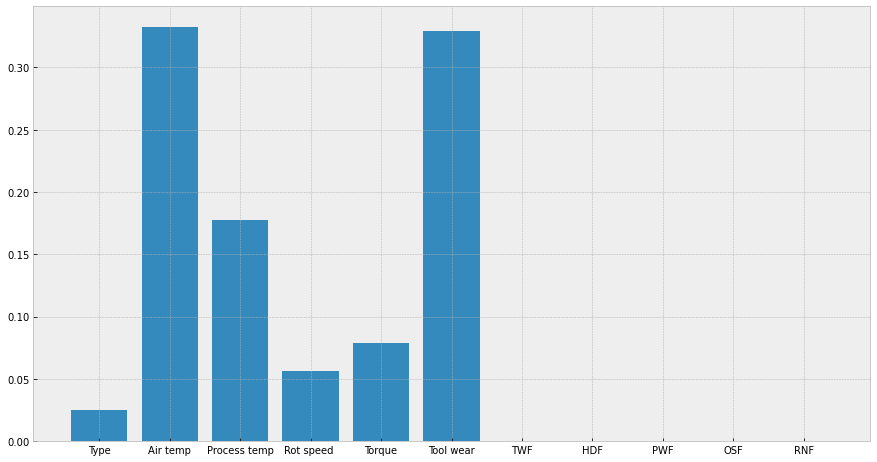

In [39]:
test = prepareDataInput(under_testingSet)
evaluateModel(under_model, test)